In [89]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils 
import shutil
import random
import torch
from PIL import Image

In [90]:
data_path = Path.cwd() / "datasets"
dataset_path = utils.download_dataset("clinical cultures",
                                   dest_path=data_path,
                                   extract=True)

Downloading:
Image dataset of urine test results on petri dishes for deep learning classification
> Authors: Gabriel Rodrigues da Silva, Igor Batista Rosmaninho, Eduardo Zancul
> Year: 2023
> Website: https://www.sciencedirect.com/science/article/pii/S235234092300152X

File already exists


Extracting xrbtd74pfj-3.zip: 100%|██████████| 1504/1504 [00:03<00:00, 376.91it/s]


In [91]:
main_data_path = list(dataset_path.glob("*"))[0]

# Remove the uncertain folder
uncertain_path = main_data_path / "Uncertain"
if uncertain_path.exists():
    shutil.rmtree(uncertain_path)

pos_images = list(main_data_path.glob("**/Positive/*.jpg"))
neg_images = list(main_data_path.glob("**/Negative/*.jpg"))


In [92]:
rnd_ix = random.randint(0, len(pos_images) - 1)
img = Image.open(pos_images[rnd_ix])
img.size


(3024, 3024)

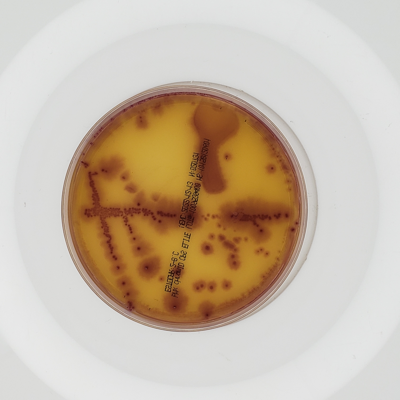

In [101]:
img = img.resize((400, 400))
img

(300, 300)


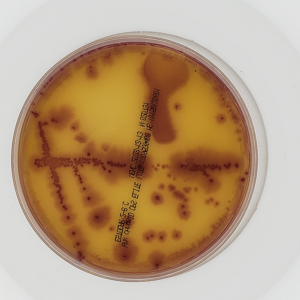

In [103]:
img_ctr_x = img.size[0] // 2
img_ctr_y = img.size[1] // 2

cropped = img.crop((img_ctr_x - 150, img_ctr_y - 150, img_ctr_x + 150, img_ctr_y + 150))
print(cropped.size)
cropped

In [104]:
from torchvision import transforms

ts = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.CenterCrop((300, 300)),
    transforms.ToTensor(),
])

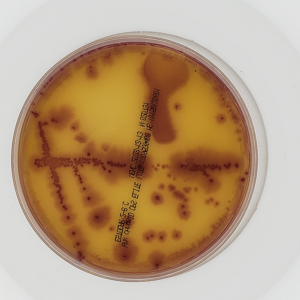

In [105]:
img_tensor = ts(img)
img_tensor.shape

# display the tensor as an image with PIL
img_tensor_pil = transforms.ToPILImage()(img_tensor)
img_tensor_pil

# Resizing the images

In [106]:
# Resize the images in the folders to 512x512
images= pos_images + neg_images 
utils.resize_images_in_folder(images, (400, 400))

Resizing images: 100%|██████████| 998/998 [00:48<00:00, 20.41it/s] 


In [107]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

ts = transforms.Compose([
    transforms.CenterCrop((300, 300)),
    transforms.ToTensor(),
])

data = ImageFolder(main_data_path, transform=ts)
train_ds, val_ds, test_ds = random_split(data, [0.8, 0.1, 0.1])

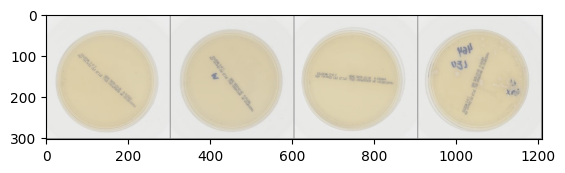

tensor([0, 0, 0, 1])


In [108]:
# visualize the first image in the dataset
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
train_loader = DataLoader(val_ds, batch_size=4, shuffle=True)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(labels)

In [109]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [110]:
images[0].max(), images[0].min()

(tensor(0.9255), tensor(0.))

In [113]:
class simpleCNN(torch.nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(16 * 150 * 150, 32)
        self.fc2 = torch.nn.Linear(32, 3)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 150 * 150)  # Flatten the tensor
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_v1 = simpleCNN()
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_v1.parameters(), lr=1e-2)
num_epochs = 25

simpleCNN Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 13


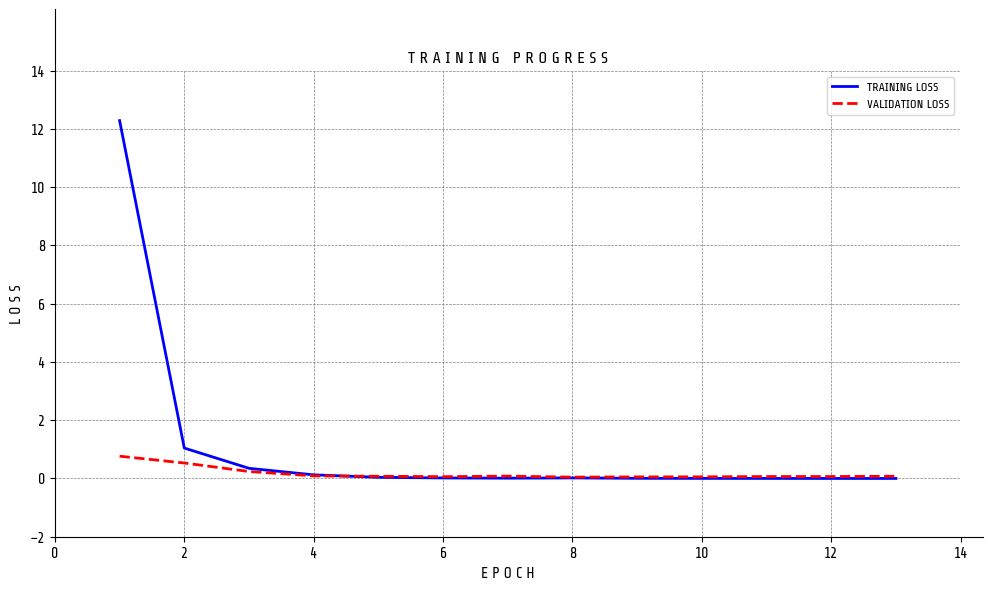

In [114]:
model_v1 = utils.train_model(model_v1,
                             criterion,
                             optimiser,
                             train_loader=train_dl,
                             val_loader=val_dl,
                             num_epochs=num_epochs,
                             early_stopping=True,
                             patience=5,
                             plot_loss=True)

In [ ]:
model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        outputs = model_v1(images.to('cuda'))
        print(outputs[:-1])
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        break

tensor([[  1.0786,   0.3218,  -4.4440],
        [ -1.7114,   4.4640,  -7.7305],
        [  1.1319,   0.2403,  -4.3438],
        [ -1.4871,   4.1805,  -7.1024],
        [  1.1103,   0.2706,  -4.3618],
        [ -4.1257,   9.2361, -14.2581],
        [  1.1414,   0.2307,  -4.3548],
        [  1.1260,   0.2507,  -4.3528],
        [ -5.6950,  12.4341, -18.1296],
        [  1.1347,   0.2186,  -4.2956],
        [  1.0888,   0.3183,  -4.4406],
        [  0.2307,   1.5452,  -5.4131],
        [  1.0090,   0.4188,  -4.5399],
        [  1.1289,   0.2440,  -4.3485],
        [  1.1246,   0.2596,  -4.3900],
        [  0.1452,   1.6849,  -5.2555],
        [ -2.2973,   5.7004,  -9.2124],
        [  1.0568,   0.3647,  -4.4455],
        [  0.9749,   0.4866,  -4.5715],
        [  1.1475,   0.2216,  -4.3406],
        [ -0.8861,   3.2088,  -6.3369],
        [  1.0912,   0.2905,  -4.3773],
        [  0.8596,   0.6709,  -4.8011],
        [  1.0382,   0.3824,  -4.4620],
        [ -6.5793,  14.0570, -21.0026],


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_accuracy(model, test_dataloader):
    model.eval()
    acc = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc += utils.accuracy_score(labels, predicted)

    return acc / len(test_dataloader)

compute_accuracy(model_v1, test_dl)

0.7994791666666666

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_labels = []
test_preds = []

model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v1(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

    Negative       0.78      0.98      0.87        53
    Positive       0.97      0.67      0.79        46

    accuracy                           0.84        99
   macro avg       0.87      0.83      0.83        99
weighted avg       0.87      0.84      0.83        99



## Regularisation methods
When using convolutional neural networks, we can use regularisation methods to prevent overfitting and to stabilise the training process. The most common regularisation methods are:
- **Dropout**: Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.
- **L2 regularisation**: Adds a penalty on the size of the weights to the loss function. This is also known as weight decay.
- **Batch Normalisation**: Normalises the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilise the learning process and can lead to faster convergence.
- **Data augmentation**: Increases the diversity of the training set by applying random transformations to the input data, such as rotation, translation, and scaling. This helps to improve the generalisation of the model.

In [ ]:
class regularizedCNN(torch.nn.Module):
    def __init__(self):
        super(regularizedCNN, self).__init__()
        # Reduced number of filters in conv layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(32 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 3)
        # Keep dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.2)
        # Keep batch normalization for more stable training
        self.batch_norm1 = torch.nn.BatchNorm2d(32)
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.nn.functional.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 32 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model_v2 = regularizedCNN()
criterion_reg = torch.nn.CrossEntropyLoss()
optimiser_reg = torch.optim.Adam(model_v2.parameters(),
                                 lr=1e-3,
                                 weight_decay=1e-3,
                                 )
num_epochs_reg = 25

In [ ]:
model_v2 = utils.train_model(model_v2,
                  criterion_reg,
                  optimiser_reg,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_reg,
                  early_stopping=True,
                  patience=5,
                  plot_loss=True)

regularizedCNN Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
compute_accuracy(model_v2, test_dl)

1.0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_labels = []
test_preds = []

model_v2.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v2(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        47
    Positive       1.00      1.00      1.00        52

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

